In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import pickle
import re
from datetime import datetime
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer

In [8]:
df = pd.read_csv('E:\Backup F4 26.04.2023\Downloads\chatgpt_style_reviews_dataset.xlsx - Sheet1.csv')

In [9]:
df.head()

,date,title,review,rating,username,helpful_votes,review_length,platform,language,location,version,verified_purchase
0,########,Review title 1,"Not satisfied, many bugs and issues.",1,user1,80,6,Amazon,zh,Kenya,2.1.4,No
1,########,Review title 2,Amazing quality and user-friendly interface.,5,user2,180,5,Flipkart,zh,France,1.2.3,No
2,########,Review title 3,"Terrible experience, needs major improvements.",2,user3,154,5,Flipkart,pt,USA,1.2.3,No
3,########,Review title 4,Poor performance and not user-friendly.,1,user4,96,5,Amazon,es,Qatar,2.1.4,Yes
4,########,Review title 5,"Not satisfied, many bugs and issues.",2,user5,139,6,Website,ar,Kenya,2.1.4,No


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   date               500 non-null    object
 1   title              500 non-null    object
 2   review             500 non-null    object
 3   rating             500 non-null    int64 
 4   username           500 non-null    object
 5   helpful_votes      500 non-null    int64 
 6   review_length      500 non-null    int64 
 7   platform           500 non-null    object
 8   language           500 non-null    object
 9   location           500 non-null    object
 10  version            500 non-null    object
 11  verified_purchase  500 non-null    object
dtypes: int64(3), object(9)
memory usage: 47.0+ KB


In [11]:
print(df.shape)

(500, 12)


In [12]:
df.isnull().sum()

date                 0
title                0
review               0
rating               0
username             0
helpful_votes        0
review_length        0
platform             0
language             0
location             0
version              0
verified_purchase    0
dtype: int64

datetime cleaning

In [13]:
print(df['date'])

0      ########
1      ########
2      ########
3      ########
4      ########
         ...   
495    7/5/2024
496    ########
497    ########
498    ########
499    9/8/2024
Name: date, Length: 500, dtype: object


In [14]:
df['date'].isna().sum()

np.int64(0)

In [15]:
df['date'].value_counts().head()

date
########    358
3/7/2024      4
3/2/2024      4
2/1/2025      4
2/3/2024      4
Name: count, dtype: int64

In [16]:
#Replace "########" with NaN
df['date'] = df['date'].replace('########', np.nan)


In [17]:
df['date'].isna().sum()

np.int64(358)

1️⃣ Dataset for EDA & time analysis

In [18]:
df_time = df.copy()

df_time['date'] = df_time['date'].replace('######', np.nan)
df_time['date'] = pd.to_datetime(df_time['date'], errors='coerce')
df_time = df_time.dropna(subset=['date'])


In [19]:
df_time

,date,title,review,rating,username,helpful_votes,review_length,platform,language,location,version,verified_purchase
5,2024-05-05,Review title 6,"Waste of time, does not meet expectations.",2,user6,156,7,App Store,en,Nepal,3.5.6,No
6,2024-03-09,Review title 7,"Highly satisfied, the app works exactly as exp...",4,user7,186,8,Google Play,fr,Qatar,2.1.4,No
7,2024-03-08,Review title 8,"Highly satisfied, the app works exactly as exp...",4,user8,152,8,Amazon,ja,Italy,5.0.3,No
14,2024-06-02,Review title 15,Works fine but there is room for improvement.,3,user15,78,8,Flipkart,hi,USA,3.5.6,Yes
18,2024-06-05,Review title 19,"Excellent app, very easy to use and extremely ...",5,user19,33,9,Website,pt,USA,5.0.3,No
...,...,...,...,...,...,...,...,...,...,...,...,...
481,2025-03-06,Review title 482,"Waste of time, does not meet expectations.",1,user482,144,7,Flipkart,en,Germany,4.2.1,Yes
488,2024-01-04,Review title 489,"Highly satisfied, the app works exactly as exp...",4,user489,123,8,Website,zh,Italy,4.2.1,No
490,2024-04-04,Review title 491,"Terrible experience, needs major improvements.",1,user491,12,5,Flipkart,en,Qatar,4.2.1,Yes
495,2024-07-05,Review title 496,"Waste of time, does not meet expectations.",2,user496,81,7,Flipkart,ja,Qatar,1.2.3,No


2️⃣ Dataset for MODEL TRAINING

In [20]:
df_model = df.copy()

In [21]:
df_model

,date,title,review,rating,username,helpful_votes,review_length,platform,language,location,version,verified_purchase
0,NaN,Review title 1,"Not satisfied, many bugs and issues.",1,user1,80,6,Amazon,zh,Kenya,2.1.4,No
1,NaN,Review title 2,Amazing quality and user-friendly interface.,5,user2,180,5,Flipkart,zh,France,1.2.3,No
2,NaN,Review title 3,"Terrible experience, needs major improvements.",2,user3,154,5,Flipkart,pt,USA,1.2.3,No
3,NaN,Review title 4,Poor performance and not user-friendly.,1,user4,96,5,Amazon,es,Qatar,2.1.4,Yes
4,NaN,Review title 5,"Not satisfied, many bugs and issues.",2,user5,139,6,Website,ar,Kenya,2.1.4,No
...,...,...,...,...,...,...,...,...,...,...,...,...
495,7/5/2024,Review title 496,"Waste of time, does not meet expectations.",2,user496,81,7,Flipkart,ja,Qatar,1.2.3,No
496,NaN,Review title 497,"Great experience, smooth performance and usefu...",5,user497,48,7,Google Play,fr,Nepal,2.1.4,No
497,NaN,Review title 498,"Terrible experience, needs major improvements.",2,user498,16,5,Google Play,de,Poland,2.1.4,Yes
498,NaN,Review title 499,"Highly satisfied, the app works exactly as exp...",4,user499,68,8,Google Play,zh,Nepal,1.2.3,Yes


In [22]:
df['rating'].value_counts()

rating
4    110
2    106
3    105
5     90
1     89
Name: count, dtype: int64

In [23]:
df['version'].value_counts()

version
4.2.1    113
1.2.3    106
2.1.4     95
3.5.6     93
5.0.3     93
Name: count, dtype: int64

In [24]:
# Get numerical columns
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
print("Numerical Columns:")
print(numerical_cols)

# Get string (object) columns
string_cols = df.select_dtypes(include=['object', 'string']).columns.tolist()
print("\nString Columns:")
print(string_cols)

# Get datetime columns
datetime_cols = df.select_dtypes(include=['datetime64[ns]']).columns
print("\nDatetime Columns:")
print(datetime_cols)


Numerical Columns:
['rating', 'helpful_votes', 'review_length']

String Columns:
['date', 'title', 'review', 'username', 'platform', 'language', 'location', 'version', 'verified_purchase']

Datetime Columns:
Index([], dtype='object')


review cleaning

In [25]:
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Deepi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Deepi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [26]:
df['review'] = df['review'].fillna('')

In [27]:
def clean_review(text):
    if pd.isna(text):
        return ""

    # 1. Convert to lowercase
    text = text.lower()

    # 2. Remove URLs
    text = re.sub(r'http\S+|www\S+', '', text)

    # 3. Remove special characters & numbers
    text = re.sub(r'[^a-z\s]', '', text)

    # 4. Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()

    # 5. Remove stopwords
    stop_words = set(stopwords.words('english'))
    text = ' '.join(word for word in text.split() if word not in stop_words)

    # 6. Lemmatization
    lemmatizer = WordNetLemmatizer()
    text = ' '.join(lemmatizer.lemmatize(word) for word in text.split())

    return text


In [28]:
df['clean_review'] = df['review'].apply(clean_review)

In [29]:
df['clean_review']

0                               satisfied many bug issue
1                 amazing quality userfriendly interface
2             terrible experience need major improvement
3                          poor performance userfriendly
4                               satisfied many bug issue
                             ...                        
495                          waste time meet expectation
496    great experience smooth performance useful fea...
497           terrible experience need major improvement
498           highly satisfied app work exactly expected
499                        poor performance userfriendly
Name: clean_review, Length: 500, dtype: object

In [30]:
#Feature engineering 
def label_sentiment(rating):
    if rating <= 2:
        return 'Negative'
    elif rating == 3:
        return 'Neutral'
    else:
        return 'Positive'

df['sentiment'] = df['rating'].apply(label_sentiment)

In [31]:
df['sentiment'].value_counts()

sentiment
Positive    200
Negative    195
Neutral     105
Name: count, dtype: int64

C:\Users\Deepi\AppData\Local\Temp\ipykernel_8080\2200193819.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df['sentiment'], palette='pastel')


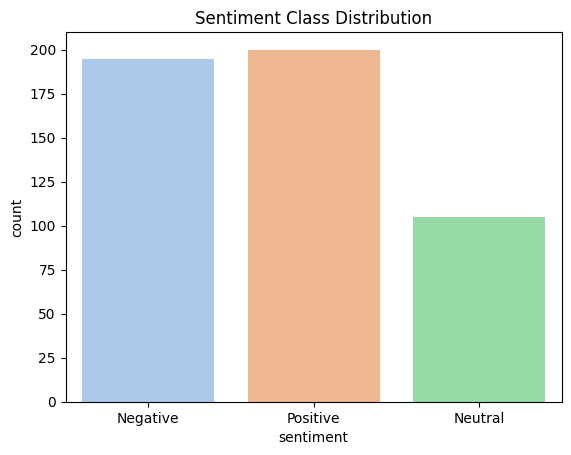

In [32]:
sns.countplot(x=df['sentiment'], palette='pastel')
plt.title("Sentiment Class Distribution")
plt.show()

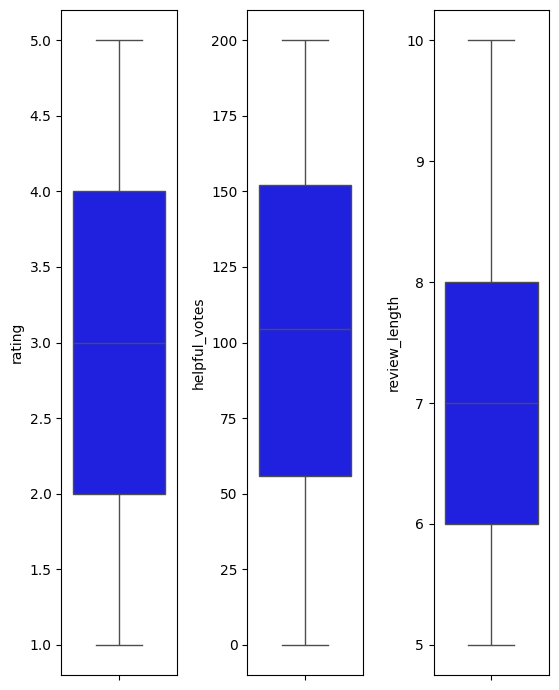

In [33]:
from scipy.stats import skew
features = ['rating', 'helpful_votes','review_length']
plt.figure(figsize=(15, 7))
for i in range(0, len(features)):
    plt.subplot(1, 8, i+1)
    sns.boxplot(y=df[features[i]],color='blue',)
    plt.tight_layout()


In [34]:
df.to_csv(r"D:\AiEcho\cleaned chatgpt.csv", index=False)
print("Cleaned CSV saved successfully at: D:\AiEcho\cleaned chatgpt.csv")

Cleaned CSV saved successfully at: D:\AiEcho\cleaned chatgpt.csv


EDA

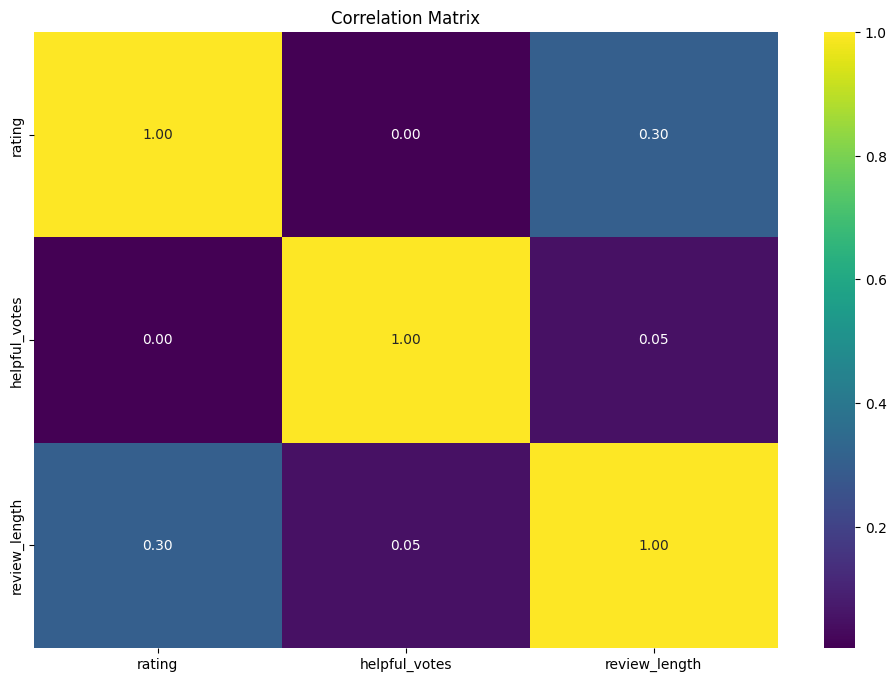

In [35]:
# Step 1: Generate the correlation matrix (only for numeric columns)
correlation_matrix = df.corr(numeric_only=True)

# Step 2: Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='viridis', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()



1. Rating Distribution: Overall Sentiment Breakdown 

C:\Users\Deepi\AppData\Local\Temp\ipykernel_8080\1346561287.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='rating', data=df,palette='colorblind')


Text(0.5, 1.0, 'Rating Distribution')

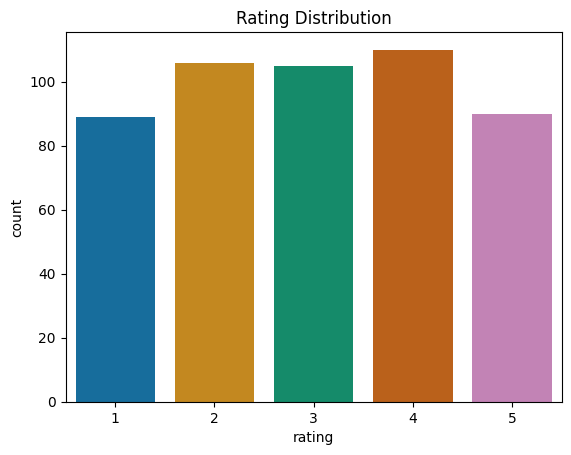

In [38]:
sns.countplot(x='rating', data=df,palette='colorblind')
plt.title('Rating Distribution')

2. Community Value: Count of Reviews Voted "Helpful" 

In [39]:
import platform
#Identify a font that supports emojis based on your OS
system_os = platform.system()
if system_os == "Windows":
    emoji_font = "Segoe UI Emoji"
elif system_os == "Darwin":  # macOS
    emoji_font = "Apple Color Emoji"
else:  # Linux (requires noto-fonts-emoji package)
    emoji_font = "Noto Color Emoji"

In [40]:
THRESHOLD = 10   # you can change this value

df["helpful_label"] = df["helpful_votes"].apply(
    lambda x: "Helpful (>10 votes)" if x > THRESHOLD else "Not Helpful (≤10 votes)")

helpful_counts = df["helpful_label"].value_counts()
print(helpful_counts)


helpful_label
Helpful (>10 votes)        473
Not Helpful (≤10 votes)     27
Name: count, dtype: int64


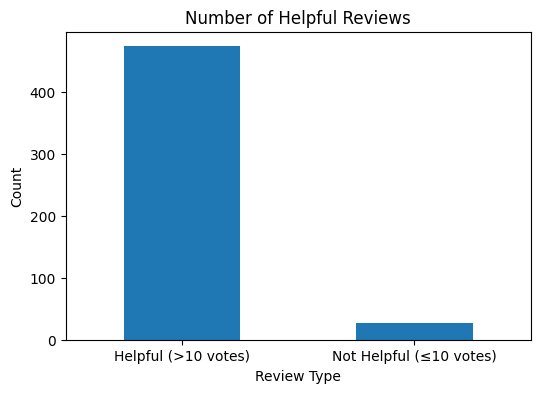

In [41]:
plt.figure(figsize=(6,4))
helpful_counts.plot(kind="bar")

plt.title("Number of Helpful Reviews")
plt.xlabel("Review Type")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.show()


3. Sentiment Drivers: Keyword Comparison of Positive vs. Negative Reviews

In [42]:
#Split Positive & Negative Reviews
positive_reviews = df[df["rating"].isin([4, 5])]["review"]
negative_reviews = df[df["rating"].isin([1, 2])]["review"]


In [43]:
#Text Cleaning Function
def clean_text(text_series):
    text = " ".join(text_series.dropna().astype(str))
    text = text.lower()
    text = "".join([char for char in text if char.isalpha() or char == " "])
    words = text.split()
    words = [word for word in words if word not in stop_words]
    return " ".join(words)


In [44]:

positive_text = clean_text(positive_reviews)
negative_text = clean_text(negative_reviews)


In [45]:
#Generate Word Clouds
positive_wc = WordCloud(
    width=600,
    height=400,
    background_color="white"
).generate(positive_text)

negative_wc = WordCloud(
    width=600,
    height=400,
    background_color="black"
).generate(negative_text)


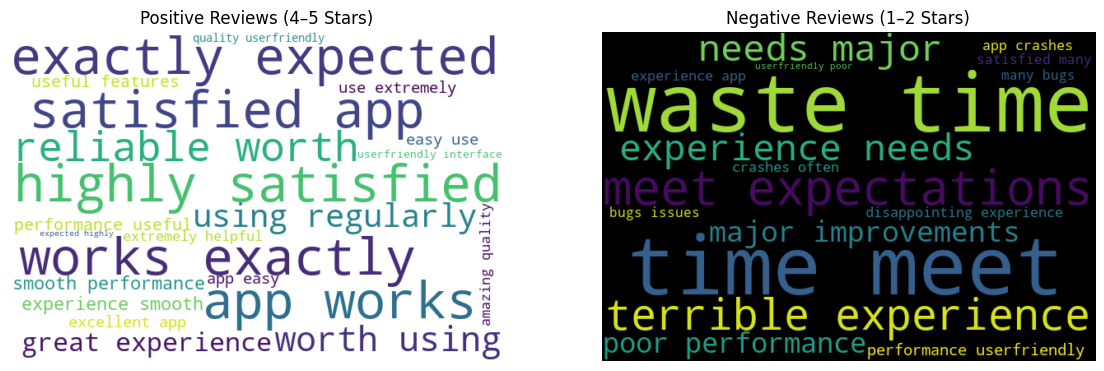

In [46]:
#Visualize Side-by-Side Word Clouds
plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
plt.imshow(positive_wc, interpolation="bilinear")
plt.axis("off")
plt.title("Positive Reviews (4–5 Stars)")

plt.subplot(1,2,2)
plt.imshow(negative_wc, interpolation="bilinear")
plt.axis("off")
plt.title("Negative Reviews (1–2 Stars)")

plt.show()


4. Satisfaction Trends: Average Rating Over Time

In [50]:
#Extracting month
df_time["month"] = df_time["date"].dt.to_period("M")


In [52]:
#Calculate Average Rating per Month
monthly_avg_rating = (
    df_time.groupby("month")["rating"]
    .mean()
    .reset_index()
)

monthly_avg_rating["month"] = monthly_avg_rating["month"].astype(str)


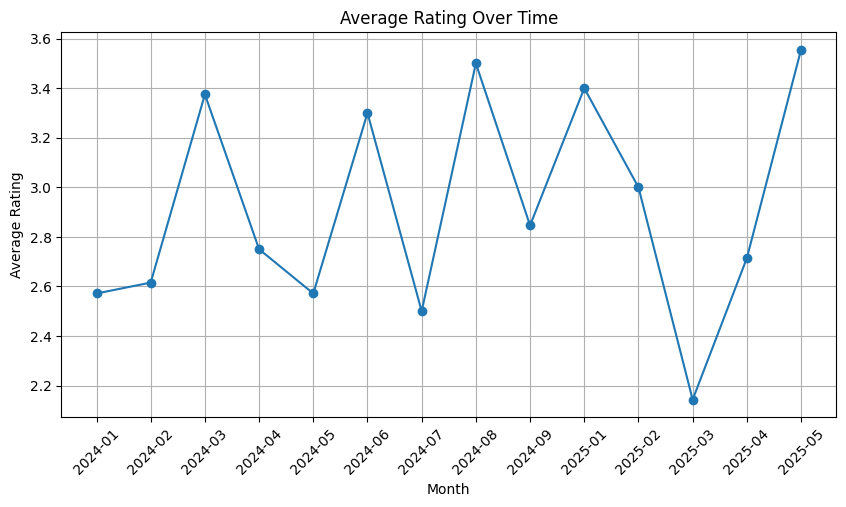

In [53]:
#Line Plot of Average Rating Over Time
plt.figure(figsize=(10,5))
plt.plot(
    monthly_avg_rating["month"],
    monthly_avg_rating["rating"],
    marker="o"
)

plt.title("Average Rating Over Time")
plt.xlabel("Month")
plt.ylabel("Average Rating")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


5. Geographical Insights: Rating Variance by User Location

Text(0.5, 1.0, 'Top 10 Locations by Review Count')

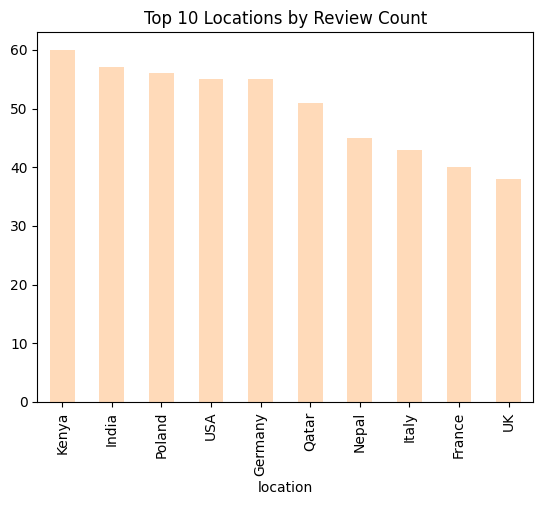

In [56]:
df['location'].value_counts().head(10).plot(kind='bar', color='peachpuff')

plt.title('Top 10 Locations by Review Count')         

6. Platform Performance: Web vs. Mobile Satisfaction Comparison

Text(0.5, 1.0, 'Top Platforms in Reviews')

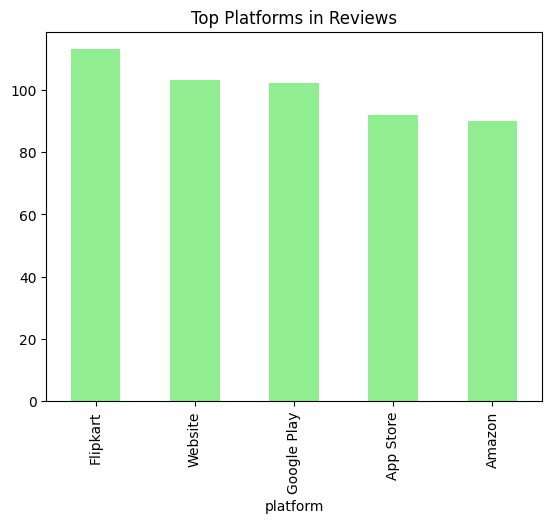

In [58]:
df['platform'].value_counts().head(10).plot(kind='bar', color='lightgreen')
plt.title('Top Platforms in Reviews')

7. User Trust: Rating Disparity Between Verified and Non-Verified Reviewers

Text(0.5, 1.0, 'Verified Purchase Distribution')

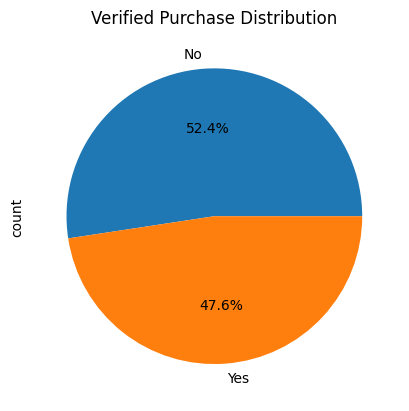

In [59]:
df['verified_purchase'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Verified Purchase Distribution')

8. Feedback Depth: Average Review Length per Star Category


C:\Users\Deepi\AppData\Local\Temp\ipykernel_8080\1857097740.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df,x='rating', y='review_length',palette="muted")


Text(0.5, 1.0, 'Review Length by Rating')

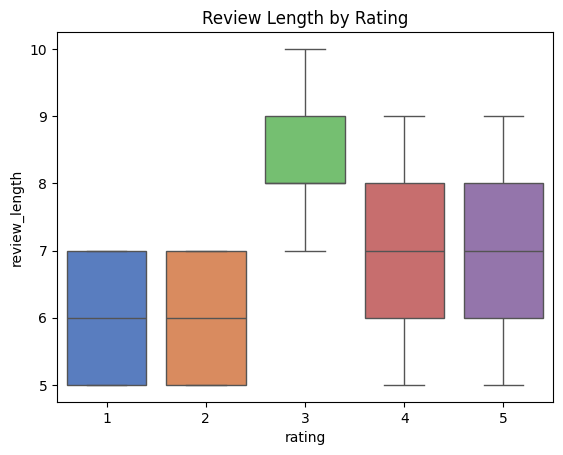

In [60]:
sns.boxplot(data=df,x='rating', y='review_length',palette="muted")
plt.title('Review Length by Rating')

9. Pain Points: Top Terms Mentioned in 1-Star Reviews

In [61]:
#filter one star reviews
one_star_reviews = df[df["rating"] == 1]["review"].dropna()

In [62]:
cleaned_words = clean_text(one_star_reviews)


In [63]:
display(cleaned_words)

'satisfied many bugs issues poor performance userfriendly terrible experience needs major improvements poor performance userfriendly satisfied many bugs issues waste time meet expectations satisfied many bugs issues disappointing experience app crashes often poor performance userfriendly disappointing experience app crashes often waste time meet expectations waste time meet expectations waste time meet expectations terrible experience needs major improvements terrible experience needs major improvements satisfied many bugs issues waste time meet expectations terrible experience needs major improvements terrible experience needs major improvements disappointing experience app crashes often waste time meet expectations poor performance userfriendly terrible experience needs major improvements poor performance userfriendly terrible experience needs major improvements poor performance userfriendly satisfied many bugs issues satisfied many bugs issues satisfied many bugs issues satisfied ma

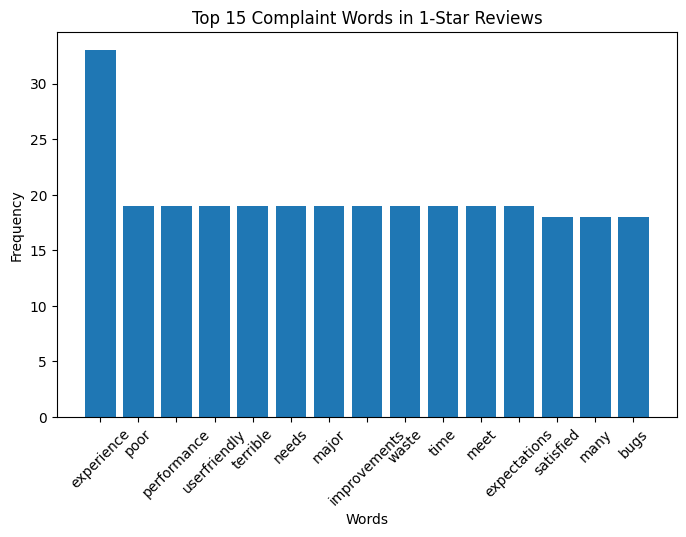

In [64]:
from collections import Counter

# FIX: Split the string into a list of words if it isn't already
if isinstance(cleaned_words, str):
    cleaned_words = cleaned_words.split()

word_freq = Counter(cleaned_words)
top_words = word_freq.most_common(15)

# Separate the words and their counts for plotting
words, counts = zip(*top_words)

plt.figure(figsize=(8,5))
plt.bar(words, counts)
plt.xticks(rotation=45)
plt.title("Top 15 Complaint Words in 1-Star Reviews")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.show()


10. Product Evolution: Average Rating by ChatGPT Version

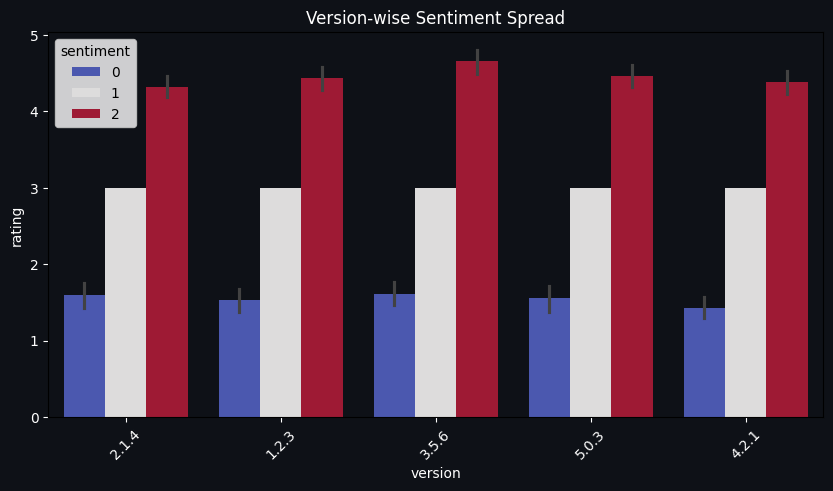

In [71]:
# Initialize the plot with a dark background
fig8, ax8 = plt.subplots(figsize=(10, 5), facecolor="#0E1117") 
ax8.set_facecolor("#0E1117")

# Create the barplot
# sns.barplot defaults to showing the mean with a 95% confidence interval error bar
sns.barplot(
    data=df, 
    x='version', 
    y='rating', 
    hue='sentiment', 
    palette='coolwarm', 
    dodge=True, 
    ax=ax8
) 

# Styling the axes and labels for visibility
plt.xticks(rotation=45, color='white') 
plt.yticks(color='white')
ax8.set_title("Version-wise Sentiment Spread", color='white') 
ax8.xaxis.label.set_color('white')
ax8.yaxis.label.set_color('white')
ax8.tick_params(colors='white') 

# Display the plot in the notebook
plt.show()

Handling Imbalance

In [67]:
# Separate classes
df_negative = df[df.sentiment == 'Negative']
df_neutral = df[df.sentiment == 'Neutral']
df_positive = df[df.sentiment == 'Positive']

# Downsample majority classes to match Neutral
df_negative_down = resample(df_negative, replace=False, n_samples=len(df_neutral), random_state=42)
df_positive_down = resample(df_positive, replace=False, n_samples=len(df_neutral), random_state=42)

# Combine balanced dataset
df_balanced = pd.concat([df_negative_down, df_neutral, df_positive_down])

In [68]:
print(df_balanced['sentiment'].value_counts())

sentiment
Negative    105
Neutral     105
Positive    105
Name: count, dtype: int64


label encoding

In [69]:
# List of categorical columns
categorical_cols = ['platform', 'language', 'location', 'verified_purchase',
                     'title', 'clean_review','sentiment','username']	

# Initialize LabelEncoder
le = LabelEncoder()

# Apply encoding
for col in categorical_cols:
    df[col] = le.fit_transform(df[col])

In [70]:
display(df.head())

,date,title,review,rating,username,helpful_votes,review_length,platform,language,location,version,verified_purchase,clean_review,sentiment,helpful_label
0,NaN,0,"Not satisfied, many bugs and issues.",1,0,80,6,0,8,4,2.1.4,0,11,0,Helpful (>10 votes)
1,NaN,111,Amazing quality and user-friendly interface.,5,111,180,5,2,8,0,1.2.3,0,0,2,Helpful (>10 votes)
2,NaN,222,"Terrible experience, needs major improvements.",2,222,154,5,2,7,9,1.2.3,0,12,0,Helpful (>10 votes)
3,NaN,333,Poor performance and not user-friendly.,1,333,96,5,0,3,7,2.1.4,1,9,0,Helpful (>10 votes)
4,NaN,444,"Not satisfied, many bugs and issues.",2,444,139,6,4,0,4,2.1.4,0,11,0,Helpful (>10 votes)


MODEL

In [72]:
def rating_to_sentiment(r):
    if r <= 2:
        return "negative"
    elif r == 3:
        return "neutral"
    else:
        return "positive"

df['sentiment'] = df['rating'].apply(rating_to_sentiment)


In [73]:
df['clean_review'] = df['review'].apply(clean_review)


In [74]:
df['clean_review'] = df['review'].apply(clean_review)


In [75]:
#feature and target selection
X = df['clean_review'].astype(str)
y = df['sentiment']


In [76]:
display(y)

0      negative
1      positive
2      negative
3      negative
4      negative
         ...   
495    negative
496    positive
497    negative
498    positive
499    negative
Name: sentiment, Length: 500, dtype: object

In [77]:
display (X)

0                               satisfied many bug issue
1                 amazing quality userfriendly interface
2             terrible experience need major improvement
3                          poor performance userfriendly
4                               satisfied many bug issue
                             ...                        
495                          waste time meet expectation
496    great experience smooth performance useful fea...
497           terrible experience need major improvement
498           highly satisfied app work exactly expected
499                        poor performance userfriendly
Name: clean_review, Length: 500, dtype: object

In [78]:
# training and splitting
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [79]:
print(type(X.iloc[0]))


<class 'str'>


In [80]:
print(X_train.head())
print(type(X_train.iloc[0]))


137      disappointing experience app crash often
167      disappointing experience app crash often
7      highly satisfied app work exactly expected
263                reliable worth using regularly
275        amazing quality userfriendly interface
Name: clean_review, dtype: object
<class 'str'>


In [81]:
#Text Vectorization (TF-IDF)
tfidf = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2)
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)


In [82]:
#Train Logistic Regression Model
model = LogisticRegression(
    max_iter=1000,
    random_state=42
)

model.fit(X_train_tfidf, y_train)


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [83]:
#Prediction
y_pred = model.predict(X_test_tfidf)


In [84]:
#Model Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 1.0

Classification Report:
               precision    recall  f1-score   support

    negative       1.00      1.00      1.00        39
     neutral       1.00      1.00      1.00        21
    positive       1.00      1.00      1.00        40

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100


Confusion Matrix:
 [[39  0  0]
 [ 0 21  0]
 [ 0  0 40]]


2 random forest

In [85]:
#Train Random Forest Model
model_rf = RandomForestClassifier(
    random_state=42
)

model_rf.fit(X_train_tfidf, y_train)


,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [86]:
#Prediction
y_pred = model_rf.predict(X_test_tfidf)


In [87]:
#Model Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 1.0

Classification Report:
               precision    recall  f1-score   support

    negative       1.00      1.00      1.00        39
     neutral       1.00      1.00      1.00        21
    positive       1.00      1.00      1.00        40

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100


Confusion Matrix:
 [[39  0  0]
 [ 0 21  0]
 [ 0  0 40]]


NAIVE BAYES MODEL

In [88]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Train model
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)

# Prediction
y_pred_nb = nb_model.predict(X_test_tfidf)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred_nb))
print("\nClassification Report:\n", classification_report(y_test, y_pred_nb))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_nb))


Accuracy: 1.0

Classification Report:
               precision    recall  f1-score   support

    negative       1.00      1.00      1.00        39
     neutral       1.00      1.00      1.00        21
    positive       1.00      1.00      1.00        40

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100


Confusion Matrix:
 [[39  0  0]
 [ 0 21  0]
 [ 0  0 40]]


In [ ]:
pickle.dump(model, open("NLP_model.pkl", "wb"))
pickle.dump(tfidf, open("tfidf_vectorizer.pkl", "wb"))